In [1]:
%load_ext lab_black
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import os
import string

np.random.seed(1234)

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False

In [2]:
COMPILE_DATA = False

if COMPILE_DATA:
    df_single = pd.read_csv(
        "../experiments/02-region-locus-simulate/results/single-causal-simulation.tsv",
        sep="\t",
    )
    df_multiple = []
    for group in ["causal", "clump"]:
        df = pd.read_csv(
            f"../experiments/02-chrom-locus-simulate/results/multiple-causal.{group}.tsv",
            sep="\t",
        )
        df = df[df.hsq == "10\%"].drop(columns=["hsq"])
        df.insert(0, "group", group)
        df_multiple.append(df)
    df_multiple = pd.concat(df_multiple, axis=0)

    df_single.to_csv("data/Figure6.single-causal.csv", index=False)
    df_multiple.to_csv("data/Figure6.multi-causal.csv", index=False)

In [3]:
def get_mean_sem(text: np.ndarray):
    """
    Parse mean and sem from a text array [mean (sem), ...,]
    """
    mean = np.array([float(f.split("(")[0]) for f in text])
    sem = np.array([float(f.split("(")[1].strip(")")) for f in text])
    return mean, sem


def add_legend(fig, axes, y, x=0.5):
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        ncol=len(handles),
        loc="center",
        bbox_to_anchor=[x, y],
        frameon=False,
        fontsize=9,
        handletextpad=0.02,
    )

In [4]:
def plot_single_causal(df_single, axes):
    colors = ["#e41a1c", "#377eb8"]
    for group_i, group in enumerate(["Causal", "Clumped (all)"]):
        df_group = df_single[df_single.group == group]

        for metric_i, metric in enumerate(
            ["HET FPR", "Deming (EUR$\sim$AFR)", "OLS (EUR$\sim$AFR)"]
        ):
            ax = axes[metric_i]
            if metric_i == 0:
                label = group.split("(")[0]
            else:
                label = None

            hsq_list = ["0.2%", "0.6%", "1.0%"]
            metric_mean, metric_sem = get_mean_sem(df_group[metric])
            ax.errorbar(
                np.arange(len(hsq_list)) - 0.1 + 0.2 * group_i,
                metric_mean,
                yerr=metric_sem * 1.96,
                fmt=".",
                ms=5,
                mew=1,
                label=label,
                linewidth=1,
                color=colors[group_i],
            )

            hline = [0.05, 1.0, 1.0][metric_i]
            ylabel = ["HET FPR", "Deming slope", "OLS slope"][metric_i]
            ylim = [[0, 0.35], [0.5, 1.5], [0.5, 1.5]][metric_i]
            ax.axhline(y=hline, color="black", ls="--", alpha=0.3)
            ax.set_xticks(np.arange(len(hsq_list)))
            ax.set_xticklabels(hsq_list)
            ax.set_xlim(-0.5, len(hsq_list) - 0.5)
            if metric_i != 0:
                ax.set_yticks([0.5, 1.0, 1.5])
            ax.set_ylabel(ylabel, fontsize=9)
            ax.set_ylim(ylim)

    for i, ax in enumerate(axes):
        ax.text(
            -0.2,
            1.06,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

In [5]:
def plot_multiple_causal(df, axes):
    colors = ["#e41a1c", "#377eb8"]

    for group_i, group in enumerate(["causal", "clump"]):
        df_group = df[df.group == group]

        for metric_i, metric in enumerate(
            ["HET FPR", "Deming (EUR$\sim$AFR)", "OLS (EUR$\sim$AFR)"]
        ):
            ax = axes[metric_i]
            if metric_i == 0:
                label = ["Causal", "Clumped"][group_i]
            else:
                label = None

            ncausal_list = df_group["ncausal"]
            metric_mean, metric_sem = get_mean_sem(df_group[metric])
            ax.errorbar(
                np.arange(len(ncausal_list)) - 0.1 + 0.2 * group_i,
                metric_mean,
                yerr=metric_sem * 1.96,
                fmt=".",
                ms=5,
                mew=1,
                label=label,
                linewidth=1,
                color=colors[group_i],
            )

            hline = [0.05, 1.0, 1.0][metric_i]
            ylabel = ["HET FPR", "Deming slope", "OLS slope"][metric_i]
            ylim = [[0, 0.35], [0.5, 1.5], [0.5, 1.5]][metric_i]
            ax.axhline(y=hline, color="black", ls="--", alpha=0.3)
            ax.set_xticks(np.arange(len(ncausal_list)))
            ax.set_xticklabels([0.25, 0.5, 1.0, 2.0, 4.0], fontsize=9)
            ax.set_xlim(-0.5, len(ncausal_list) - 0.5)
            if metric_i != 0:
                ax.set_yticks([0.5, 1.0, 1.5])
            ax.set_ylabel(ylabel, fontsize=9)
            ax.set_ylim(ylim)

    for i, ax in enumerate(axes):
        ax.text(
            -0.2,
            1.06,
            string.ascii_lowercase[i + 3],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

In [6]:
df_single = pd.read_csv("data/Figure6.single-causal.csv")
df_multiple = pd.read_csv("data/Figure6.multi-causal.csv")

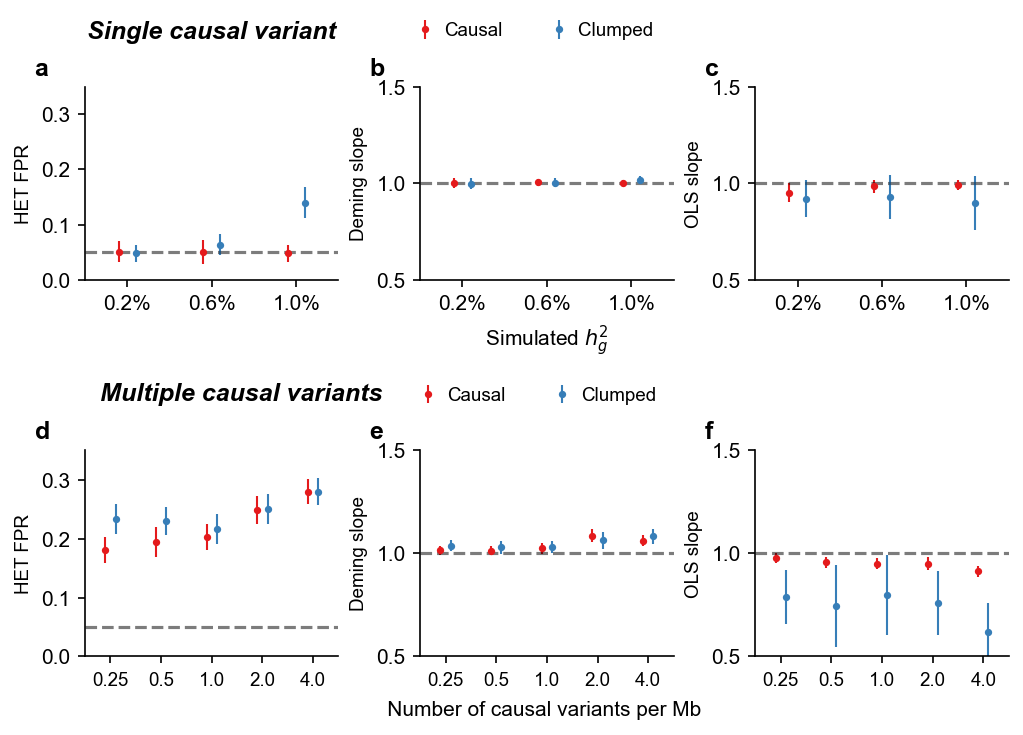

In [7]:
fig = plt.figure(dpi=150, figsize=(6.7, 4.5), constrained_layout=True)
# trick
fig.suptitle(" ", y=1.05)

subfigs = fig.subfigures(nrows=2, ncols=1)

## single causal
axes = subfigs[0].subplots(nrows=1, ncols=3)
plot_single_causal(df_single, axes)
subfigs[0].supxlabel(" " * 12 + "Simulated $h_g^2$", fontsize=10)
subfigs[0].suptitle(
    "Single causal variant",
    x=0.2,
    y=1.1,
    fontweight="bold",
    style="italic",
)

add_legend(fig, axes, y=1.03, x=0.52)

## multiple causals
axes = subfigs[1].subplots(nrows=1, ncols=3)
plot_multiple_causal(df_multiple, axes)
subfigs[1].supxlabel(" " * 11 + "Number of causal variants per Mb", fontsize=10)
subfigs[1].suptitle("Multiple causal variants")
subfigs[1].suptitle(
    "Multiple causal variants",
    x=0.23,
    y=1.1,
    fontweight="bold",
    style="italic",
)
add_legend(fig, axes, y=0.49, x=0.52)

fig.set_constrained_layout_pads(hspace=0.15)
fig.savefig("out/Figure6.pdf", bbox_inches="tight")